In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import db
import pasttrec_ctrl as ptc
import json
import baseline_calib
from my_utils import *
import tdc_daq as td
import matplotlib.pyplot as plt
import time

Welcome to JupyROOT 6.14/04


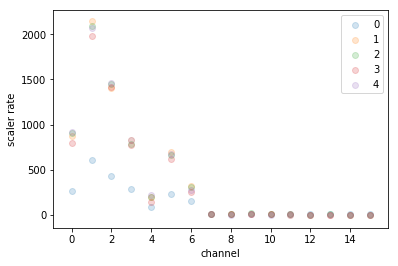

In [2]:
#db.board_list()


name = "0017"
trend_scaler_list = []
for i in range(0,5):
    time.sleep(1)
    db.unset_standby_board(name)
    ptc.init_board_by_name(name,10,i,15)
    scaler_list = []
    #ptc.reset_board_by_name("0017")
    #ptc.init_active_boards()
    scaler_list = td.scaler_rate_of_board(name,0.2)
    trend_scaler_list += [scaler_list]
    plt.scatter(range(0,16),scaler_list,alpha=0.2,label = "{:d}".format(i))
    plt.legend()
    plt.xlabel("channel")
    plt.ylabel("scaler rate")
plt.show()
# db.dump_db_to_root("ee.root")    
# for my_board in db.nostandby_board_list():
#     print(my_board)

In [3]:
## scan threshold of an single board as function of peaking time, gain, number of other boards switched on

import ROOT

# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)


#for my_board in db.board_list():
#  db.unset_standby_board(my_board) #name = "0029" #PASSTEC board id (inside )

c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
ROOT.gStyle.SetOptFit(1)
n_wires = 162
mg = ROOT.TMultiGraph()
mg2 = ROOT.TMultiGraph()
gr = [1, 2, 3, 4]
gr2 = [1, 2, 3, 4]
dependency_list = []

index_l = 0
for p in [1,2,4]:    
    for my_board in db.board_list():
         db.set_standby_board(my_board)
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
     # vary peakingtime:
    print("gain: ", p)
    ptc.init_board_by_name(name,10,p,15)  # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):
    #time.sleep(60)
    dependency_list += [ p ]
    
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)
    calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]

    #scaler_list = []
    #scaler_list = td.scaler_rate_of_board(name,0.2)
    root_name = "/workdir/noise_scan0" + str(p) + ".root"
    print(root_name)
    db.dump_db_to_root_board(root_name,name)


gain:  1
/workdir/noise_scan01.root
scanning keys of board: 0017
dumping data of board: 0017
gain:  2
/workdir/noise_scan02.root
scanning keys of board: 0017
dumping data of board: 0017
gain:  4
/workdir/noise_scan04.root
scanning keys of board: 0017
dumping data of board: 0017


>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

/workdir/noise_scan01.root
/workdir/noise_scan02.root
/workdir/noise_scan04.root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file noiseFit_lay3_wire64_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire65_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire66_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire67_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire68_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire69_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire70_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire71_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire72_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire73_scan1.png has been created
Info in <TCanvas::Print>: png file noiseFit_lay3_wire74_scan1.png has been created
Info in <TCanvas::

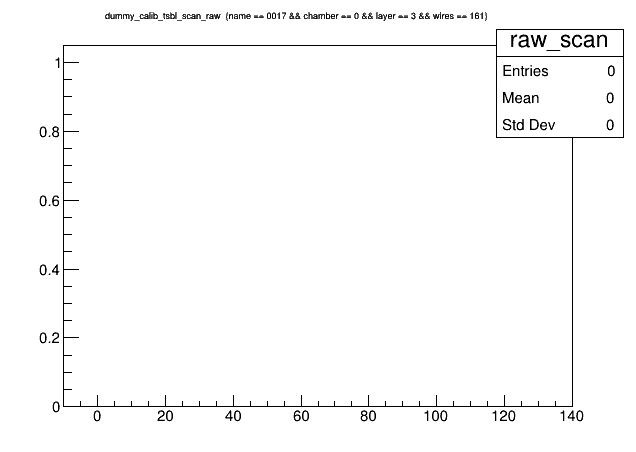

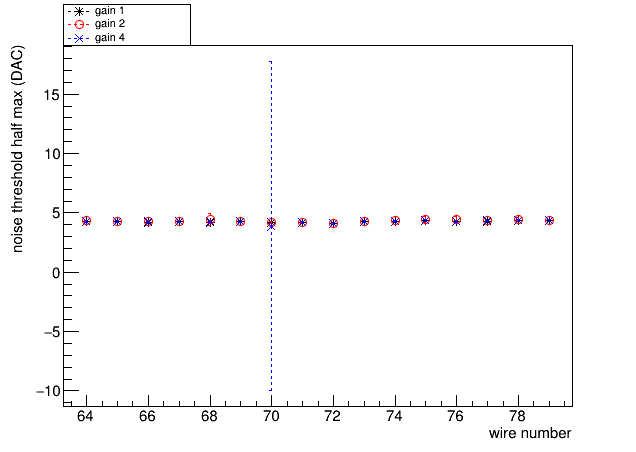

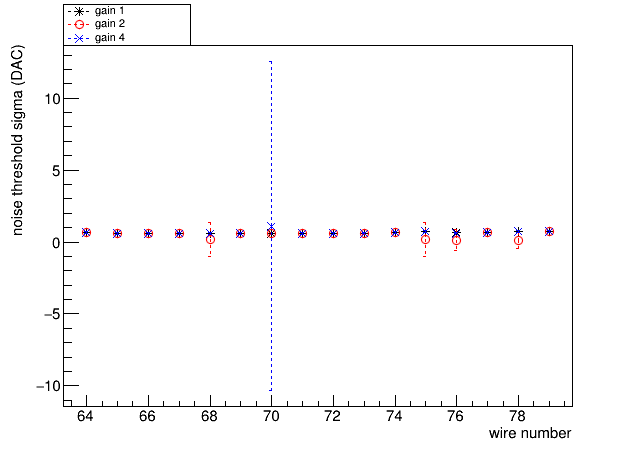

In [6]:
import root_fit as fit
color_contrast_array = [1,632,600,417,800,616,401,880,807,633,634,626,797,617,618]
c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
ROOT.gStyle.SetOptFit(1)
n_wires = 162
mg = ROOT.TMultiGraph()
mg2 = ROOT.TMultiGraph()
legend = ROOT.TLegend(0.1,0.9,0.3,0.99);
gr = [1, 2, 3, 4]
gr2 = [1, 2, 3, 4]
dependency_list = []
index_l = -1
for p in [1,2,4]:   # PASTTREC gain scan
#for p in [1,2,4]:   # PASTTREC peakingtime scan
    dependency_list += [ p ]
    root_name = "/workdir/noise_scan0" + str(p) + ".root"
    print(root_name)
    f = ROOT.TFile(root_name)
    dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
    index_l += 1
    gr[index_l] = ROOT.TGraphErrors(); 
    gr[index_l].SetMarkerStyle(3+index_l); gr[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    gr[index_l].SetLineStyle(2); gr[index_l].SetLineColor(color_contrast_array[index_l]);
    gr2[index_l] = ROOT.TGraphErrors(); gr2[index_l].SetMarkerStyle(3+index_l);
    gr2[index_l].SetMarkerStyle(3+index_l); gr2[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    gr2[index_l].SetLineStyle(2); gr2[index_l].SetLineColor(color_contrast_array[index_l]);    
    for l in range(2,4):
#         index_l += 1
        stdev_list = []
        sigma_list = []
        mean_list = []    
        sigma_list_err = []
        mean_list_err = []  
        ipoint = 0
        for i in range(0,n_wires):
           c.cd() 
       #dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(120,-20,100)","chamber == 0 && layer == 3 && name == 0015 && board_chan == " + str(i) ,"colz")
           ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(150,-10,140)","name == " + name + " && chamber == 0 && layer == " + str(l) + " && wires == " + str(i) )  
           if (ndata > 0): 
               raw_scan = f.Get("raw_scan")
               results = fit.fit_scurve(raw_scan)
               raw_scan.Draw()
               c.Draw()
               c.SaveAs("noiseFit_lay" + str(l) +"_wire" + str(i) +"_scan" + str(p) +".png")
               gr[index_l].SetPoint(ipoint, i, np.double(results[2]))
               gr[index_l].SetPointError(ipoint, 0, np.double(results[3]) )
               gr2[index_l].SetPoint(ipoint, i, np.double(results[4]))
               gr2[index_l].SetPointError(ipoint, 0, np.double(results[5]) )
               ipoint += 1
    mg.Add(gr[index_l]); gr[index_l].SetTitle("layer " + str(l) ); 
    mg2.Add(gr2[index_l]); gr2[index_l].SetTitle("layer " + str(l) );  

   #legend->SetHeader("The Legend Title","C"); // option "C" allows to center the header
    legend.AddEntry(gr[index_l],"gain " + str(p),"lp")
  


c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
mg.Draw("ap")
mg.GetXaxis().SetTitle("wire number");
mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
legend.Draw()
c1.Draw()
c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
c2.cd();
mg2.Draw("ap")
mg2.GetXaxis().SetTitle("wire number");
mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
legend.Draw()
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::SaveAs>: ROOT file board0017_scan_mean.root has been created
Info in <TCanvas::SaveAs>: ROOT file board0017_scan_sigma.root has been created


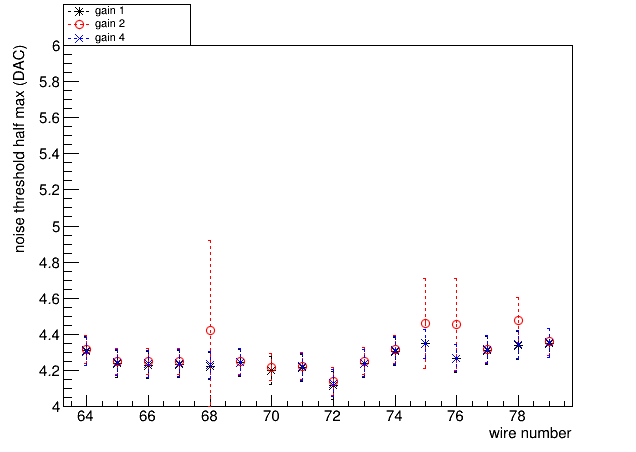

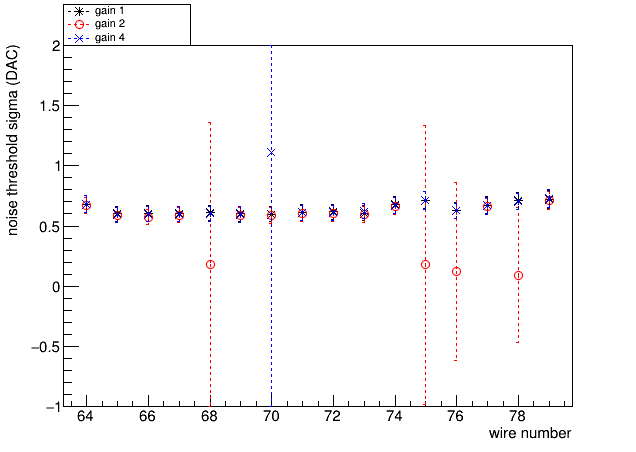

In [7]:

c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
mg.Draw("ap")
mg.GetXaxis().SetTitle("wire number");
mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
mg.GetYaxis().SetRangeUser(4,6)
mg.Draw("ap")
legend.Draw()
c1.Draw()
c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
c2.cd();
mg2.Draw("ap")
mg2.GetXaxis().SetTitle("wire number");
mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
mg2.GetYaxis().SetRangeUser(-1,2)
mg2.Draw("ap")
legend.Draw()
c2.Draw()

c1.SaveAs("board" + name + "_scan_mean.root")
c2.SaveAs("board" + name + "_scan_sigma.root")